# **Importing Libraries (PIMA Dataset) - FL**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import math
from torch.utils import data
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import cv2
import matplotlib.image as mpimg
import csv
import pandas as pd
import ntpath
from datetime import datetime
import argparse
import pathlib
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
#cuda recommended
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
MODEL_SAVE_PATH = './MODEL/MODEL.pth'
if not os.path.exists('./MODEL'):
  os.makedirs('./MODEL')
SAVE_DIR = './MODEL'

In [ ]:
num_clients = 2
num_selected = (
    2 # Number of randomly selected clients from num_clients during communication round
)
num_rounds = 10
epochs = 250  # Total number of local training rounds on each selected client’s device.
batch_size = 32

In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset, Subset

torch.backends.cudnn.benchmark = True
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn import preprocessing

In [ ]:
dataset = pd.read_csv("/content/diabetes.csv")
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
X = dataset.drop("Outcome",axis=1)
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [ ]:
Y = dataset["Outcome"]
Y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(614, 8)
(614,)
(154, 8)
(154,)


In [ ]:
import torch.utils.data as data_utils

In [ ]:
scaler = MinMaxScaler()
X_train_normal = scaler.fit_transform(X_train)
X_test_normal = scaler.transform(X_test)

In [ ]:
"""
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
"""
Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

In [ ]:
X_train = np.expand_dims(X_train, axis = 0)
X_test = np.expand_dims(X_test, axis = 0)

In [ ]:
X_train = np.transpose(X_train)
X_test = np.transpose(X_test)

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(32911, 1)
(32911,)
(14105, 1)
(14105,)


In [ ]:
X_train

array([[ 1.88746202],
       [15.6865797 ],
       [ 8.86858368],
       ...,
       [10.57938004],
       [ 2.45351505],
       [ 5.40565014]])

In [ ]:
Y_train

array([   0.        , 3589.39892578, 1628.5489502 , ..., 2977.06494141,
          0.        ,  348.75100708])

In [ ]:
train = data_utils.TensorDataset(torch.from_numpy(X_train_normal).float(),
                                 torch.from_numpy(Y_train).float())

In [ ]:
test = data_utils.TensorDataset(torch.from_numpy(X_test_normal).float(),
                                 torch.from_numpy(Y_test).float())

In [ ]:
length_dataset = 614
indices = np.random.permutation(len(X_train))[:length_dataset]
traindata = Subset(train, indices)
print(len(traindata))

614


In [ ]:
traindata_split = torch.utils.data.random_split(
    traindata, [int(length_dataset / num_clients) for _ in range(num_clients)]
)
print(len(traindata_split))
train_loader = [
    torch.utils.data.DataLoader(x, batch_size=32, shuffle=True)
    for x in traindata_split
]

test_loader = torch.utils.data.DataLoader(test, batch_size = 32, shuffle = True)

2


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 5)
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 2)
        #self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        #print('x', x)
        output = F.relu(self.fc1(x))
        #print('output1', output)
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

model = Net().to(device)

100%|██████████| 2/2 [00:05<00:00,  2.56s/it]


0-th round
average train loss 0.484 | test loss 0.0151 | test acc: 0.747 | f1: 0.662


100%|██████████| 2/2 [00:04<00:00,  2.05s/it]


1-th round
average train loss 0.431 | test loss 0.0141 | test acc: 0.786 | f1: 0.736


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


2-th round
average train loss 0.587 | test loss 0.0138 | test acc: 0.786 | f1: 0.736


100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


3-th round
average train loss 0.459 | test loss 0.014 | test acc: 0.792 | f1: 0.749


100%|██████████| 2/2 [00:04<00:00,  2.04s/it]


4-th round
average train loss 0.513 | test loss 0.0142 | test acc: 0.805 | f1: 0.765


100%|██████████| 2/2 [00:04<00:00,  2.31s/it]


5-th round
average train loss 0.469 | test loss 0.0138 | test acc: 0.799 | f1: 0.758


100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


6-th round
average train loss 0.385 | test loss 0.0139 | test acc: 0.792 | f1: 0.749


100%|██████████| 2/2 [00:04<00:00,  2.08s/it]


7-th round
average train loss 0.419 | test loss 0.0142 | test acc: 0.799 | f1: 0.758


100%|██████████| 2/2 [00:04<00:00,  2.30s/it]


8-th round
average train loss 0.531 | test loss 0.0139 | test acc: 0.792 | f1: 0.749


100%|██████████| 2/2 [00:04<00:00,  2.08s/it]

9-th round
average train loss 0.415 | test loss 0.0139 | test acc: 0.799 | f1: 0.755


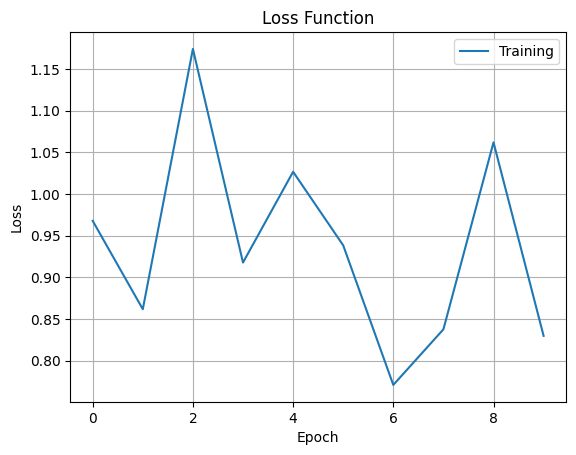

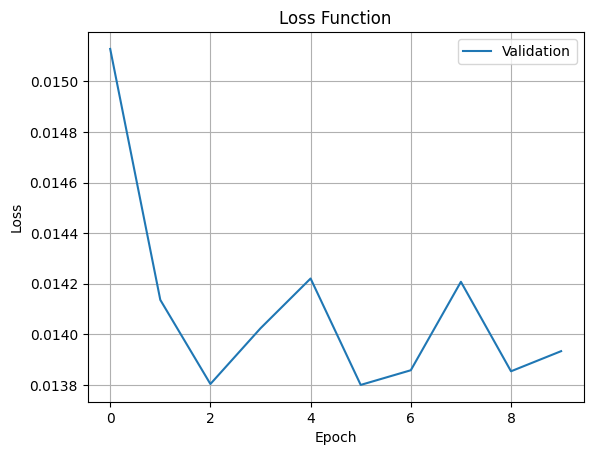

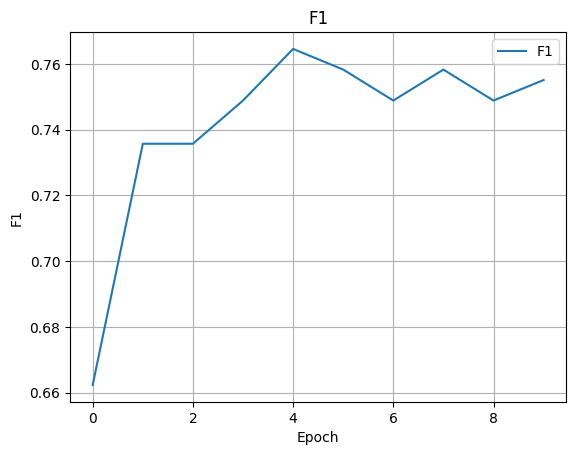

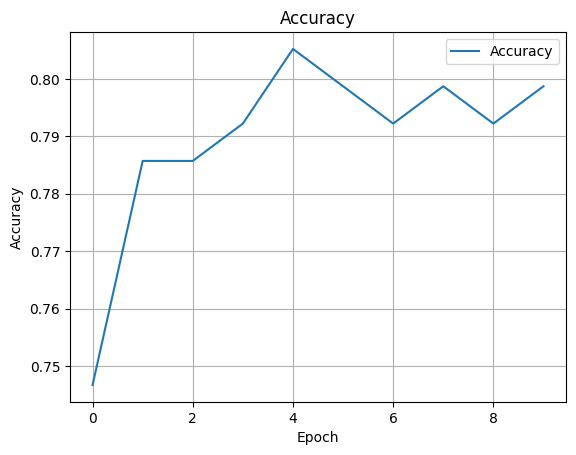

Classification Report:
-----------------------------
               precision    recall  f1-score   support

 No Diabetes       0.84      0.88      0.86       107
    Diabetes       0.69      0.62      0.65        47

    accuracy                           0.80       154
   macro avg       0.76      0.75      0.76       154
weighted avg       0.79      0.80      0.80       154



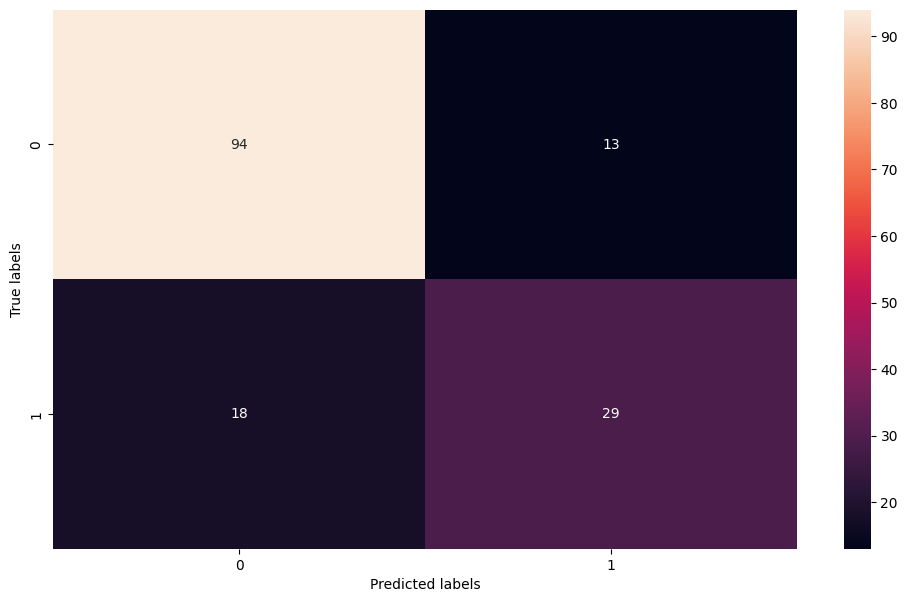

In [ ]:
def client_update(client_model, optimizer, loss_fn, train_loader, epoch=20):
    model.train()
    for e in range(epoch):
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            output = client_model(data)
            loss = loss_fn(output, labels.long())
            loss.backward()
            optimizer.step()
    return loss.item()


def server_aggregate(global_model, client_models,client_lens):
    """
    This function has aggregation method 'wmean'
    wmean takes the weighted mean of the weights of models
    """
    total = sum(client_lens)
    n = len(client_models)
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k].float()*(n*client_lens[i]/total) for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())


def test(global_model, loss_fn, test_loader):
    model.eval()
    test_loss = 0
    true_labels = []
    pred_probs = []
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            output = global_model(data)
            test_loss += loss_fn(output, labels.long()).item()
            probs = torch.softmax(output, dim=1)
            true_labels.extend(labels.tolist())
            pred_probs.extend(probs.tolist())

    test_loss /= (len(test_loader.dataset))
    acc = accuracy_score(true_labels, np.argmax(pred_probs, axis=1))
    f1 = f1_score(true_labels, np.argmax(pred_probs, axis=1), average='macro')
    #auc = roc_auc_score(true_labels, pred_probs, multi_class='ovo')
    return test_loss, acc, f1, true_labels, pred_probs




global_model = Net().to(device)


client_models = [Net().to(device) for _ in range(num_selected)]
for model in client_models:
    model.load_state_dict(
        global_model.state_dict()
    )


opt = [optim.Adam(model.parameters(),lr=0.0003) for model in client_models]
loss_fn = [nn.CrossEntropyLoss() for model in client_models]

















losses_train = []
losses_test = []
acc_train = []
acc_test = []
f1_test = []
auc_test = []
best_loss = 10000

for r in range(num_rounds):
    client_idx = np.random.permutation(num_clients)[:num_selected]
    client_lens = [len(train_loader[idx]) for idx in client_idx]
    loss = 0
    for i in tqdm(range(num_selected)):
        loss += client_update(client_models[i], opt[i], loss_fn[i], train_loader[client_idx[i]], epoch=epochs)

    losses_train.append(loss)
    server_aggregate(global_model, client_models, client_lens)
    loss_test = nn.CrossEntropyLoss()
    test_loss, acc, f1, true_labels, pred_probs = test(global_model, loss_test, test_loader)
    losses_test.append(test_loss)
    acc_test.append(acc)
    f1_test.append(f1)
    #auc_test.append(auc)
    print("%d-th round" % r)
    print(
        "average train loss %0.3g | test loss %0.3g | test acc: %0.3f | f1: %0.3f"
        % (loss / num_selected, test_loss, acc, f1)
    )
plt.plot(losses_train)
plt.title('Loss Function')
plt.legend(['Training'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()
plt.plot(losses_test)
plt.title('Loss Function')
plt.legend(['Validation'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.show()
plt.plot(f1_test)
plt.title('F1')
plt.legend(['F1'])
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid()
plt.show()

plt.plot(acc_test)
plt.title('Accuracy')
plt.legend(['Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.show()
classes = ['No Diabetes', 'Diabetes']
plt.figure(figsize = (12,7))
ax = plt.subplot()
cf_matrix = confusion_matrix(true_labels, np.argmax(pred_probs, axis=1))
sns.heatmap(cf_matrix, annot=True, fmt="g", ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
clr = classification_report(true_labels, np.argmax(pred_probs, axis=1), target_names=classes)
print("Classification Report:\n-----------------------------\n", clr)